# Facebook Graph VAE
---
Created by Lucas Hu for Teamcore AI Lab at the University of Southern California. The purpose of this notebook is to apply Graph VAE's to social network graph data (mainly, Facebook friend data) for the purposes of link prediction.

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
EDGES_DIR = 'facebook/0.edges'
FEATURES_DIR = 'facebook/0.feat'

In [3]:
# Read edge-list
f = open(EDGES_DIR)
g = nx.read_edgelist(f, nodetype=int)

In [4]:
# read features into dataframe
from pandas import read_table
df = pd.read_table(FEATURES_DIR, sep=' ', header=None, index_col=0)

In [5]:
df = df.loc[g.nodes()] # only keep connected nodes (drops unconnected nodes)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,215,216,217,218,219,220,221,222,223,224
0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


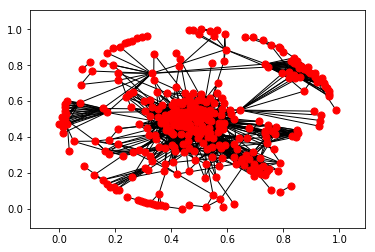

In [6]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

In [7]:
adj = nx.adjacency_matrix(g) # get adjacency matrix in sparse format
features = df.values # features matrix

## 2. Data Preprocessing

In [8]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
tf.set_random_seed(0)
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [9]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [10]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)

In [11]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

np.random.seed(0) # IMPORTANT: guarantees consistent train/test splits
adj_train, train_edges, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj, test_frac=.3, val_frac=.1)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

In [12]:
# Inspect train/test split
print("Total nodes:", adj_orig.shape[0])
print("Total edges:", int(adj_orig.nnz/2)) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print("Training edges (positive):", len(train_edges))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 333
Total edges: 2519
Training edges (positive): 1513
Validation edges (positive): 251
Validation edges (negative): 251
Test edges (positive): 755
Test edges (negative): 755


## 3. Initialize VAE Model

In [13]:
# Define hyperparameters
LEARNING_RATE = 0.005
EPOCHS = 300
HIDDEN1_DIM = 32
HIDDEN2_DIM = 16
DROPOUT = 0.1

In [14]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [15]:
# How much to weigh positive examples (true edges) in cost print_function
  # Want to weigh less-frequent classes higher, so as to prevent model output bias
  # pos_weight = (num. negative samples / (num. positive samples)
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()

# normalize (scale) average weighted cost
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [16]:
# Create VAE model
model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero,
                   HIDDEN1_DIM, HIDDEN2_DIM)

opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm,
                           learning_rate=LEARNING_RATE)

In [17]:
# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        pos.append(adj_orig[e[0], e[1]]) # actual value (1)

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        neg.append(adj_orig[e[0], e[1]]) # actual value (0)

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

## 4. Train and Evaluate VAE Model

In [18]:
cost_val = []
acc_val = []
val_roc_score = []

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train model
for epoch in range(EPOCHS):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: DROPOUT})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    # Evaluate predictions
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    # Print results for this epoch
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Print final results
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.84589 train_acc= 0.45605 val_roc= 0.78288 val_ap= 0.79451 time= 0.07176
Epoch: 0002 train_loss= 1.69019 train_acc= 0.46069 val_roc= 0.78069 val_ap= 0.79003 time= 0.03357
Epoch: 0003 train_loss= 1.49434 train_acc= 0.48801 val_roc= 0.77922 val_ap= 0.78489 time= 0.03359
Epoch: 0004 train_loss= 1.33261 train_acc= 0.49263 val_roc= 0.78625 val_ap= 0.79045 time= 0.03478
Epoch: 0005 train_loss= 1.37258 train_acc= 0.48440 val_roc= 0.79830 val_ap= 0.80364 time= 0.03491
Epoch: 0006 train_loss= 1.35700 train_acc= 0.48056 val_roc= 0.80906 val_ap= 0.81480 time= 0.03363
Epoch: 0007 train_loss= 1.25892 train_acc= 0.48794 val_roc= 0.81758 val_ap= 0.82147 time= 0.04028
Epoch: 0008 train_loss= 1.24586 train_acc= 0.48998 val_roc= 0.82399 val_ap= 0.82820 time= 0.05094
Epoch: 0009 train_loss= 1.22576 train_acc= 0.49331 val_roc= 0.82693 val_ap= 0.83030 time= 0.03891
Epoch: 0010 train_loss= 1.22036 train_acc= 0.49010 val_roc= 0.83015 val_ap= 0.83191 time= 0.03652
Epoch: 0011 train_lo

Epoch: 0085 train_loss= 0.53417 train_acc= 0.52805 val_roc= 0.87355 val_ap= 0.87382 time= 0.03913
Epoch: 0086 train_loss= 0.52792 train_acc= 0.53903 val_roc= 0.87214 val_ap= 0.87277 time= 0.04908
Epoch: 0087 train_loss= 0.52862 train_acc= 0.53855 val_roc= 0.87303 val_ap= 0.87451 time= 0.03411
Epoch: 0088 train_loss= 0.52703 train_acc= 0.53988 val_roc= 0.87484 val_ap= 0.87599 time= 0.03546
Epoch: 0089 train_loss= 0.52646 train_acc= 0.54181 val_roc= 0.87691 val_ap= 0.87716 time= 0.03446
Epoch: 0090 train_loss= 0.52819 train_acc= 0.53721 val_roc= 0.87772 val_ap= 0.87743 time= 0.03372
Epoch: 0091 train_loss= 0.52555 train_acc= 0.53734 val_roc= 0.87877 val_ap= 0.87826 time= 0.04922
Epoch: 0092 train_loss= 0.52683 train_acc= 0.54167 val_roc= 0.87882 val_ap= 0.87834 time= 0.03831
Epoch: 0093 train_loss= 0.52584 train_acc= 0.54096 val_roc= 0.87891 val_ap= 0.87912 time= 0.03440
Epoch: 0094 train_loss= 0.52433 train_acc= 0.53487 val_roc= 0.87872 val_ap= 0.88027 time= 0.03502
Epoch: 0095 train_lo

Epoch: 0173 train_loss= 0.51813 train_acc= 0.54464 val_roc= 0.89164 val_ap= 0.89321 time= 0.05850
Epoch: 0174 train_loss= 0.51513 train_acc= 0.54610 val_roc= 0.89158 val_ap= 0.89319 time= 0.08554
Epoch: 0175 train_loss= 0.51904 train_acc= 0.54082 val_roc= 0.89074 val_ap= 0.89234 time= 0.05954
Epoch: 0176 train_loss= 0.51182 train_acc= 0.55209 val_roc= 0.88930 val_ap= 0.89098 time= 0.05178
Epoch: 0177 train_loss= 0.51616 train_acc= 0.54812 val_roc= 0.88820 val_ap= 0.89046 time= 0.05389
Epoch: 0178 train_loss= 0.52104 train_acc= 0.55052 val_roc= 0.88801 val_ap= 0.89013 time= 0.04736
Epoch: 0179 train_loss= 0.51830 train_acc= 0.54122 val_roc= 0.88774 val_ap= 0.89133 time= 0.03851
Epoch: 0180 train_loss= 0.51397 train_acc= 0.54838 val_roc= 0.88691 val_ap= 0.89074 time= 0.03495
Epoch: 0181 train_loss= 0.51366 train_acc= 0.55552 val_roc= 0.88861 val_ap= 0.89225 time= 0.04140
Epoch: 0182 train_loss= 0.51477 train_acc= 0.55298 val_roc= 0.88963 val_ap= 0.89312 time= 0.03615
Epoch: 0183 train_lo

Epoch: 0260 train_loss= 0.50861 train_acc= 0.55507 val_roc= 0.90330 val_ap= 0.90534 time= 0.06110
Epoch: 0261 train_loss= 0.51154 train_acc= 0.54533 val_roc= 0.90139 val_ap= 0.90413 time= 0.06638
Epoch: 0262 train_loss= 0.51385 train_acc= 0.55191 val_roc= 0.90041 val_ap= 0.90343 time= 0.06775
Epoch: 0263 train_loss= 0.50744 train_acc= 0.55615 val_roc= 0.89999 val_ap= 0.90300 time= 0.06404
Epoch: 0264 train_loss= 0.50713 train_acc= 0.56030 val_roc= 0.89971 val_ap= 0.90250 time= 0.04340
Epoch: 0265 train_loss= 0.50908 train_acc= 0.56068 val_roc= 0.90091 val_ap= 0.90255 time= 0.04000
Epoch: 0266 train_loss= 0.50561 train_acc= 0.55841 val_roc= 0.90150 val_ap= 0.90256 time= 0.03366
Epoch: 0267 train_loss= 0.50839 train_acc= 0.55620 val_roc= 0.90212 val_ap= 0.90331 time= 0.03578
Epoch: 0268 train_loss= 0.50574 train_acc= 0.55794 val_roc= 0.90333 val_ap= 0.90512 time= 0.03518
Epoch: 0269 train_loss= 0.50603 train_acc= 0.56035 val_roc= 0.90434 val_ap= 0.90591 time= 0.04124
Epoch: 0270 train_lo